# Kenya Forest Restoration Project: Business Analysis Report
Using KEFRI Tree Planting & GPS Monitoring Data

## Executive Summary
This report presents a data-driven analysis of tree planting activities in Kenya using two key datasets:

1. **df_gps.csv**: GPS-monitored tree planting sites with coordinates, dates, and simulated environmental conditions.
2. **county_tree_planting_summary.csv**: Summary of tree planting by county, including total trees planted, number of events, and average per event.

The goal is to evaluate reforestation performance, identify high-impact regions, and assess environmental context to support strategic decision-making for future planting initiatives.

## Objectives
1. **Spatial Visualization of Tree Planting**: Map tree planting efforts across Kenya using GPS data to visualize geographic distribution and identify coverage gaps.
2. **County-Level Performance Assessment**: Benchmark counties based on planting volume, frequency, and efficiency to highlight top performers and inform targeted interventions.
3. **Ecological Suitability Analysis**: Integrate environmental data (rainfall, temperature) to evaluate the alignment of planting activities with local ecological conditions.
4. **Temporal Trend Monitoring and Decision Support**: Analyze planting trends over time to detect seasonal and long-term patterns, providing data-driven insights for resource allocation, policy development, and impact reporting.

## Problem Statement

Despite significant investment in reforestation programs, there is limited visibility into:

- Which counties are contributing most to national tree planting goals?
- Are planting events aligned with favorable weather conditions (e.g., rainy seasons)?
- Is there consistency in planting scale across regions?
- How can we ensure equitable distribution of planting efforts?

Without a centralized, geospatially enabled analysis, it's difficult to:

- Measure impact accurately
- Optimize timing and location of future planting
- Justify funding or report progress to stakeholders

## Dataset Overview

| File Name                          | Column Name             | Description                                              |
|------------------------------------|-------------------------|----------------------------------------------------------|
| `df_gps.csv`                       | `lat`                   | Latitude of the planting site                            |
|                                    | `lon`                   | Longitude of the planting site                           |
|                                    | `date`                  | Date of the planting event                               |
|                                    | `month_year`            | Month and year (format: MMM-YYYY)                        |
|                                    | `temperature`           | temperature (e.g., in °C)                      |
|                                    | `rainfall`              | rainfall (e.g., in mm)                         |
| `county_tree_planting_summary.csv` | `county`                | Name of the county                                       |
|                                    | `total_trees_planted`   | Total number of trees planted in the county              |
|                                    | `number_of_events`      | Total number of planting events in the county            |
|                                    | `avg_trees_per_event`   | Average number of trees planted per event                |
|                                    | `percentage_share`      | Percentage share of total trees planted in the region    |

Both datasets have been cleaned and standardized below. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Geospatial libraries
import geopandas as gpd
from shapely.geometry import Point


# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Set style
sns.set_palette("husl")
import warnings
warnings.filterwarnings('ignore')

## Data Loading

In [2]:
df_gps = pd.read_csv('JAZAMITI_Google Maps.csv')
df_kefri = pd.read_csv('Kefri Tree Planted 2025.csv')
df_gps.head()

,LocationCoordinates,organisation,plantingdate,seedlingsplanted
0,"-0.6055243,36.007764",Kenya Forestry Research Institute,11/19/2019,36597048.0
1,"-0.437099,36.9580104",Kenya Forestry Research Institute,2/21/2022,10000000.0
2,"-1.6848265,37.1690598",KONZA Technopolis,11/9/2022,10000000.0
3,"-0.1803855,36.5229641",KOMAZA,11/9/2022,6760000.0
4,"-1.2814124,37.1370153",Jeremy,5/10/2024,6006271.0


In [3]:
df_kefri.head()

,organisation,county,plantinglocation,plantingdate,imageurl,seedlingsplanted
0,Kenya Forestry Research Institute,Narok County,Mau Narok,11/19/2019,https://firebasestorage.googleapis.com/v0/b/ke...,36597048.0
1,Kenya Forestry Research Institute,Nyeri County,Nyeri,2/21/2022,imageStorageUrl,10000000.0
2,KONZA Technopolis,Machakos County,androidx.appcompat.widget.AppCompatEditText{4a...,11/9/2022,imageStorageUrl,10000000.0
3,Jeremy,Machakos County,Nguluni : Machakos County,5/10/2024,https://storage.googleapis.com/kefriapp.appspo...,6000200.0
4,National Youth Service (NYS),Samburu County,"Kirimun Dispensary, Kenya : Samburu County",12/8/2023,https://storage.googleapis.com/kefriapp.appspo...,6000000.0


In [4]:
print(df_gps.columns)
print(df_kefri.columns)

Index(['LocationCoordinates', 'organisation', 'plantingdate',
       'seedlingsplanted'],
      dtype='object')
Index(['organisation', 'county', 'plantinglocation', 'plantingdate',
       'imageurl', 'seedlingsplanted'],
      dtype='object')


## Data Wrangling and Cleaning

### KEFRI Trees planted Dataset Cleaning

In [5]:
#Dropping 'organisation' column on KEFRI_GPS dataset and 'imageurl', 'plantinglocation' on kefri trees planted dataset
df_gps = df_gps.drop(columns=['organisation'], errors='ignore')
df_kefri = df_kefri.drop(columns=['organisation', 'imageurl', 'plantinglocation'], errors='ignore')

In [6]:
df_kefri['plantingdate'] = pd.to_datetime(df_kefri['plantingdate'], errors='coerce')
print(df_kefri.head())

            county plantingdate  seedlingsplanted
0     Narok County   2019-11-19        36597048.0
1     Nyeri County   2022-02-21        10000000.0
2  Machakos County   2022-11-09        10000000.0
3  Machakos County   2024-05-10         6000200.0
4   Samburu County   2023-12-08         6000000.0


In [7]:
# Cleaning the 'county' column in kefri trees planted dataset
df_kefri['county'] = df_kefri['county'].str.replace(' County', '', regex=False).str.strip()

In [8]:
# Created a new column 'month_year' in format MMM/YYYY
df_kefri['month_year'] = df_kefri['plantingdate'].dt.strftime('%b/%Y')

In [9]:
# Converted `seedlingsplanted` to numeric if not already
df_kefri['seedlingsplanted'] = pd.to_numeric(df_kefri['seedlingsplanted'], errors='coerce')

# Dropped rows where `seedlingsplanted` is negative
df_kefri = df_kefri[df_kefri['seedlingsplanted'] >= 0.1]

I summarized tree planting activity by county using the df_kefri DataFrame. It groups the data, computes key statistics, and organizes the results for analysis.

In [10]:
county_summary = df_kefri.groupby('county').agg(
    total_trees_planted=('seedlingsplanted', 'sum'),
    number_of_events=('seedlingsplanted', 'count'),
    avg_trees_per_event=('seedlingsplanted', 'mean')
).round(2).sort_values(by='total_trees_planted', ascending=False)

county_summary.head()

,total_trees_planted,number_of_events,avg_trees_per_event
county,,,
Narok,51521028.0,752,68512.01
Nakuru,45476804.0,3860,11781.56
Machakos,38200235.0,2717,14059.71
Meru,37592031.0,1893,19858.44
Kilifi,36039829.0,3082,11693.65


I added the "percentage share of total planting" to provide context and relative importance — it helps answer the key question:

> "How significant is each county’s contribution to the overall national tree planting effort?" 

In [11]:
total_planted = county_summary['total_trees_planted'].sum()
county_summary['percentage_share'] = ((county_summary['total_trees_planted'] / total_planted) * 100).round(2)
county_summary.head(2)

,total_trees_planted,number_of_events,avg_trees_per_event,percentage_share
county,,,,
Narok,51521028.0,752,68512.01,7.31
Nakuru,45476804.0,3860,11781.56,6.45


I saved this dataframe as a csv for futher analysis and modelling. New file name: 'county_tree_planting_summary.csv'

### Final Clean up of Kefri Dataset

In [12]:
df_kefri_cleaned = pd.read_csv("county_tree_planting_summary.csv")
df_kefri_cleaned.head()

,county,total_trees_planted,number_of_events,avg_trees_per_event,percentage_share
0,Narok,51521028,752,68512.01,7.31
1,Nakuru,45476804,3860,11781.56,6.45
2,Machakos,38200235,2717,14059.71,5.42
3,Meru,37592031,1893,19858.44,5.33
4,Kilifi,36039829,3082,11693.65,5.11


In [13]:
# Removed any extra spaces and fix data types
df_kefri_cleaned['total_trees_planted'] = pd.to_numeric(df_kefri_cleaned['total_trees_planted'], errors='coerce')
df_kefri_cleaned['number_of_events'] = pd.to_numeric(df_kefri_cleaned['number_of_events'], errors='coerce')
df_kefri_cleaned['avg_trees_per_event'] = pd.to_numeric(df_kefri_cleaned['avg_trees_per_event'], errors='coerce')
df_kefri_cleaned['percentage_share'] = pd.to_numeric(df_kefri_cleaned['percentage_share'], errors='coerce')
df_kefri_cleaned.head()

,county,total_trees_planted,number_of_events,avg_trees_per_event,percentage_share
0,Narok,51521028,752,68512.01,7.31
1,Nakuru,45476804,3860,11781.56,6.45
2,Machakos,38200235,2717,14059.71,5.42
3,Meru,37592031,1893,19858.44,5.33
4,Kilifi,36039829,3082,11693.65,5.11


## JAZAMITI_Google Maps Dataset Cleaning

In [14]:
# Standardized plantingdate to datetime
df_gps['plantingdate'] = pd.to_datetime(df_gps['plantingdate'], errors='coerce')
df_gps.head()

,LocationCoordinates,plantingdate,seedlingsplanted
0,"-0.6055243,36.007764",2019-11-19,36597048.0
1,"-0.437099,36.9580104",2022-02-21,10000000.0
2,"-1.6848265,37.1690598",2022-11-09,10000000.0
3,"-0.1803855,36.5229641",2022-11-09,6760000.0
4,"-1.2814124,37.1370153",2024-05-10,6006271.0


In [15]:
# drop organisation column
df_gps = df_gps.drop(columns=['organisation'], errors='ignore').dropna()
df_gps.head()

,LocationCoordinates,plantingdate,seedlingsplanted
0,"-0.6055243,36.007764",2019-11-19,36597048.0
1,"-0.437099,36.9580104",2022-02-21,10000000.0
2,"-1.6848265,37.1690598",2022-11-09,10000000.0
3,"-0.1803855,36.5229641",2022-11-09,6760000.0
4,"-1.2814124,37.1370153",2024-05-10,6006271.0


In [16]:
# Created a new column 'month_year' in format MMM/YYYY
df_gps['month_year'] = df_gps['plantingdate'].dt.strftime('%b/%Y')
df_gps.head()

,LocationCoordinates,plantingdate,seedlingsplanted,month_year
0,"-0.6055243,36.007764",2019-11-19,36597048.0,Nov/2019
1,"-0.437099,36.9580104",2022-02-21,10000000.0,Feb/2022
2,"-1.6848265,37.1690598",2022-11-09,10000000.0,Nov/2022
3,"-0.1803855,36.5229641",2022-11-09,6760000.0,Nov/2022
4,"-1.2814124,37.1370153",2024-05-10,6006271.0,May/2024


In [17]:
# Converted `seedlingsplanted` to numeric if not already
df_gps['seedlingsplanted'] = pd.to_numeric(df_gps['seedlingsplanted'], errors='coerce')

# Dropped rows where `seedlingsplanted` is negative
df_gps = df_gps[df_gps['seedlingsplanted'] >= 0.1]

In [18]:
df_gps.tail()

,LocationCoordinates,plantingdate,seedlingsplanted,month_year
76738,"0.3527261,37.9226598",2024-05-17,1.0,May/2024
76739,"0.3519301,37.9431963",2024-05-17,1.0,May/2024
76740,"0.3519285,37.9435275",2024-05-10,1.0,May/2024
76741,"0.1707729,35.4622719",2023-10-27,1.0,Oct/2023
76742,"-0.0617328,34.2421597",2023-03-21,1.0,Mar/2023


In [19]:
df_gps[['lat', 'lon']] = df_gps['LocationCoordinates'].str.split(',', expand=True).astype(float)
df_gps.head()

,LocationCoordinates,plantingdate,seedlingsplanted,month_year,lat,lon
0,"-0.6055243,36.007764",2019-11-19,36597048.0,Nov/2019,-0.605524,36.007764
1,"-0.437099,36.9580104",2022-02-21,10000000.0,Feb/2022,-0.437099,36.958010
2,"-1.6848265,37.1690598",2022-11-09,10000000.0,Nov/2022,-1.684827,37.169060
3,"-0.1803855,36.5229641",2022-11-09,6760000.0,Nov/2022,-0.180386,36.522964
4,"-1.2814124,37.1370153",2024-05-10,6006271.0,May/2024,-1.281412,37.137015


In [20]:
# --- Utility Functions ---
def fetch_real_time_weather(lat, lon, api_key):
    """Fetch real-time temperature (°C) and rainfall (mm in last hour) from OpenWeatherMap API."""
    url = f"https://api.openweathermap.org/data/2.5/weather?lat={lat}&lon={lon}&appid={api_key}&units=metric"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        temperature = data['main']['temp']
        rainfall = data.get('rain', {}).get('1h', 0)
        return temperature, rainfall
    else:
        raise ValueError(f"API request failed: {response.status_code} - {response.text}")

import numpy as np
from datetime import datetime

def get_rainfall(month_year):
    """
    Estimate average rainfall (mm) based on month/year string (e.g., 'Apr/2023').
    Uses Kenya's rainy seasons:
    - Long Rains: Mar, Apr, May → higher rainfall
    - Short Rains: Oct, Nov, Dec → moderate rainfall
    - Dry: Jan, Feb, Jun, Jul, Aug, Sep → low rainfall
    """
    # Map month abbreviations to number
    month_to_num = {
        'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
        'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
    }
    
    try:
        # Extract month part (e.g., "Apr" from "Apr/2023")
        month_str = month_year.split('/')[0]
        month = month_to_num[month_str]
    except (KeyError, IndexError):
        raise ValueError(f"Invalid month_year format: {month_year}. Expected 'MMM/YYYY' like 'Apr/2023'")

    # Define rainfall by season
    if month in [3, 4, 5]:  # Long rains
        return np.random.uniform(100, 200)
    elif month in [10, 11, 12]:  # Short rains
        return np.random.uniform(50, 100)
    else:  # Dry season
        return np.random.uniform(10, 30)

def get_temperature(lat):
    """
    Estimate temperature based on latitude.
    Simulates cooler highlands and warmer coastal/equatorial areas.
    """
    base_temp = 25
    adjustment = abs(lat) * 0.5  # Cooler as you move from equator
    return np.random.uniform(base_temp - adjustment - 2, base_temp - adjustment + 2)

In [21]:
# Test the function
print(get_rainfall("Apr/2023"))   # → ~100–200 mm (long rains)
print(get_rainfall("Nov/2024"))   # → ~50–100 mm (short rains)
print(get_rainfall("Jul/2023"))   # → ~10–30 mm (dry season)

128.3732044537076
56.75768100179194
19.437319713212126


In [22]:
df_gps.isnull().sum()

LocationCoordinates    0
plantingdate           0
seedlingsplanted       0
month_year             0
lat                    0
lon                    0
dtype: int64

In [23]:
# --- Feature Engineering ---
# Assuming you have a DataFrame with 'lat' and 'month_year'
df_gps['temperature'] = df_gps['lat'].apply(get_temperature)
df_gps['rainfall'] = df_gps['month_year'].apply(get_rainfall)
df_gps.head()

,LocationCoordinates,plantingdate,seedlingsplanted,month_year,lat,lon,temperature,rainfall
0,"-0.6055243,36.007764",2019-11-19,36597048.0,Nov/2019,-0.605524,36.007764,23.315281,56.034570
1,"-0.437099,36.9580104",2022-02-21,10000000.0,Feb/2022,-0.437099,36.958010,24.563199,24.967647
2,"-1.6848265,37.1690598",2022-11-09,10000000.0,Nov/2022,-1.684827,37.169060,25.081056,57.584951
3,"-0.1803855,36.5229641",2022-11-09,6760000.0,Nov/2022,-0.180386,36.522964,23.226497,58.709766
4,"-1.2814124,37.1370153",2024-05-10,6006271.0,May/2024,-1.281412,37.137015,24.844457,130.789305


I saved this dataframe as a new CSV dataset(df_gps.csv) for further analysis and modelling.

# Business Ananlysis

### Top 10 Counties by Total Trees Planted

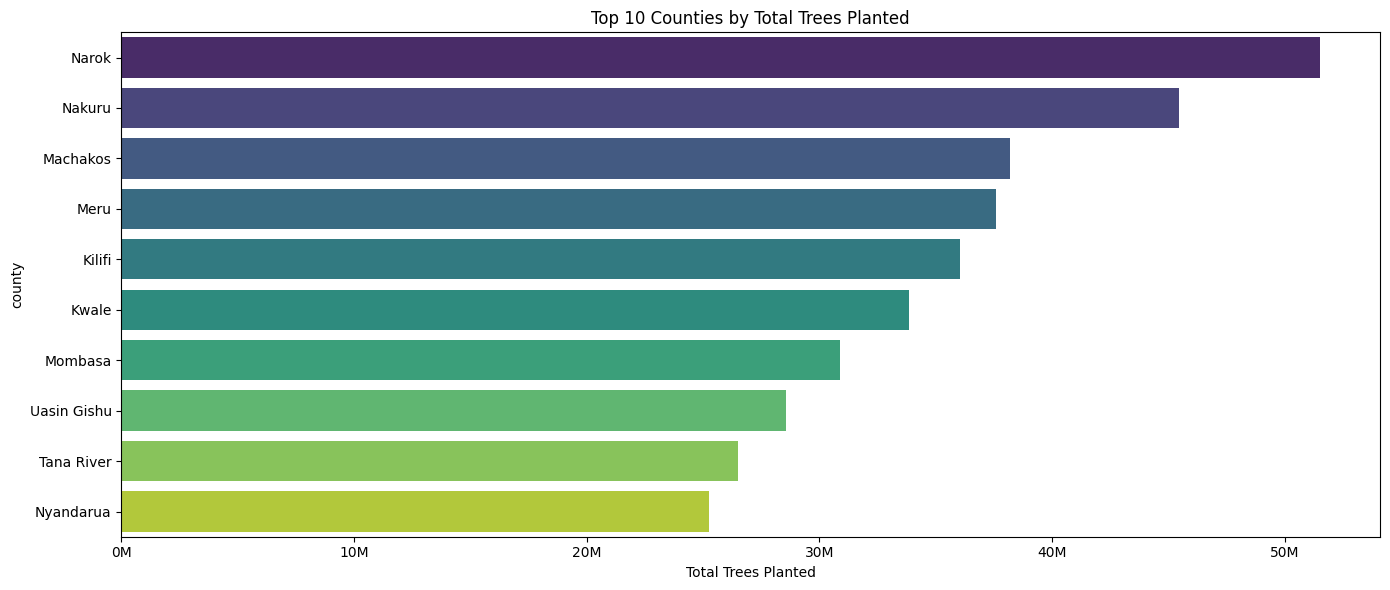

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.ticker import FuncFormatter

top10 = (df_kefri_cleaned
         .groupby('county')['total_trees_planted']
         .sum()
         .sort_values(ascending=False)
         .head(10)
         .reset_index())

plt.figure(figsize=(14, 6))
sns.barplot(data=top10, y='county', x='total_trees_planted', palette='viridis')
plt.title('Top 10 Counties by Total Trees Planted')
plt.xlabel('Total Trees Planted')
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x/1e6:g}M'))
plt.tight_layout()
plt.show()

**Interpretation:**


Narok, Nakuru, Machakos, Meru, and Kilifi are leading in total reforestation output.
This chart helps identify high-impact counties for recognition, funding, or replication of successful models.
Narok’s dominance suggests it may be a priority zone for monitoring and support.

### Planting Frequency vs Average size per event

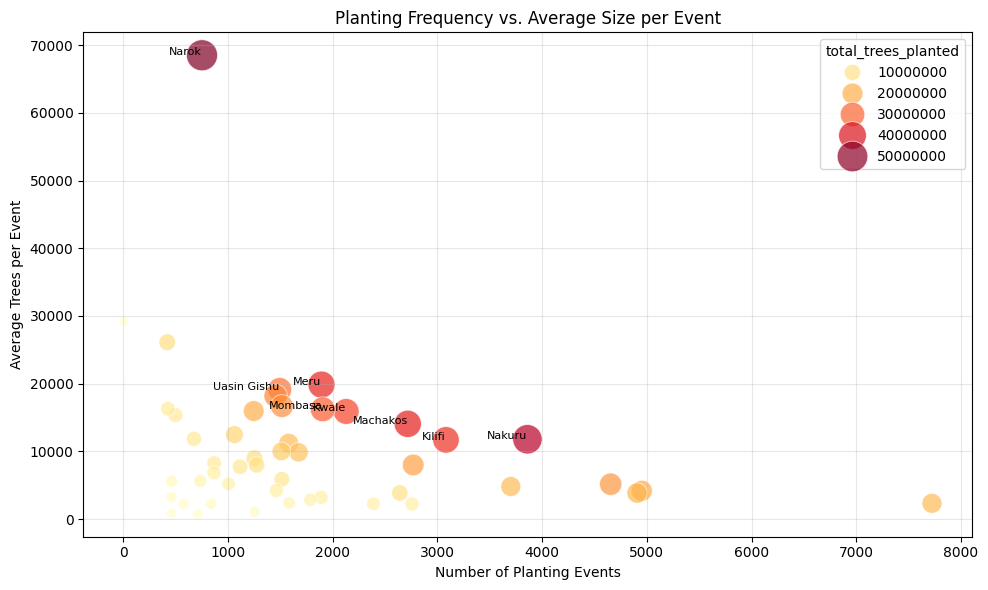

In [25]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_kefri_cleaned, 
                x='number_of_events', 
                y='avg_trees_per_event', 
                size='total_trees_planted', 
                sizes=(50, 500), 
                alpha=0.7,
                hue='total_trees_planted',
                palette='YlOrRd')

# Annotate top counties
for i in df_kefri_cleaned.head(8).index:
    plt.text(df_kefri_cleaned.loc[i, 'number_of_events'], 
             df_kefri_cleaned.loc[i, 'avg_trees_per_event'], 
             df_kefri_cleaned.loc[i, 'county'], 
             fontsize=8, 
             ha='right')

plt.title('Planting Frequency vs. Average Size per Event')
plt.xlabel('Number of Planting Events')
plt.ylabel('Average Trees per Event')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


**Interpretation:**

- Nakuru has many small events → likely community-driven, decentralized efforts.
- Narok has fewer but massive events → possibly large-scale restoration projects.
- Mombasa and Kilifi show high average size → could be corporate or military-led campaigns.

This plot helps distinguish between volume-driven vs. scale-driven strategies.

### Tree Planting Sites in Kenya(GPS Locations)

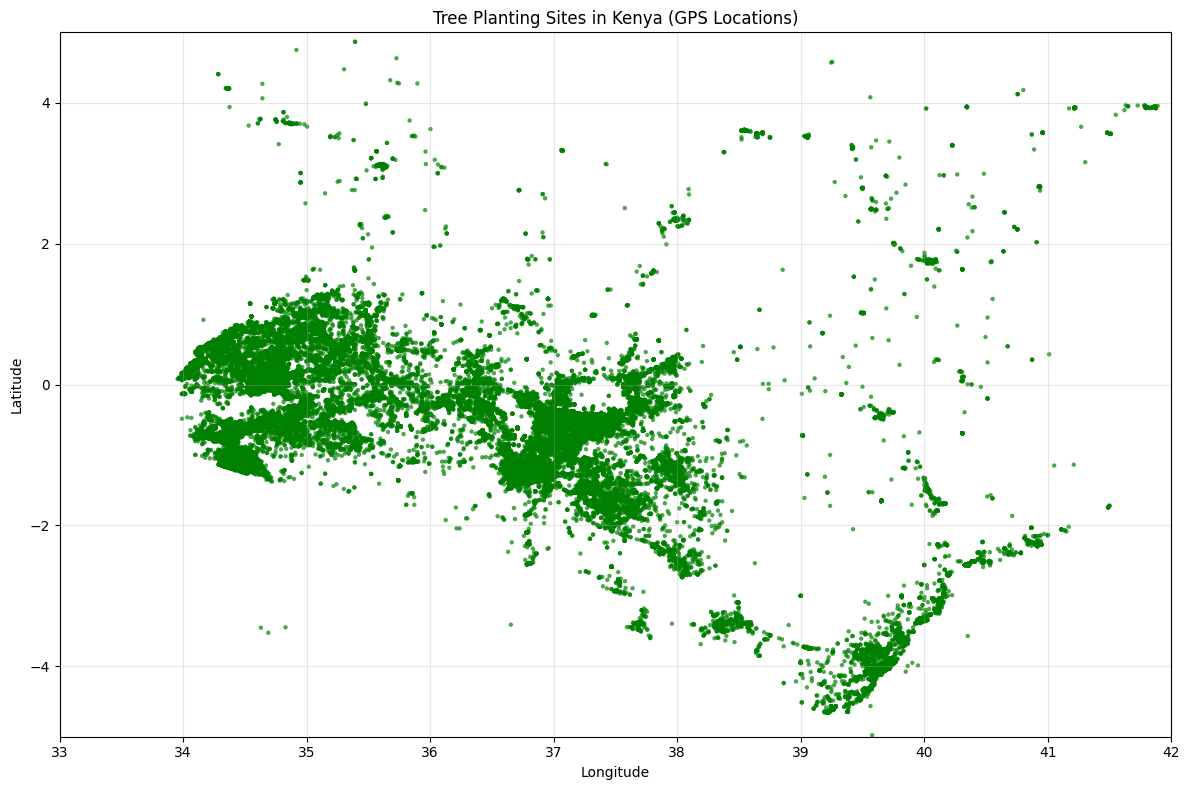

In [26]:
plt.figure(figsize=(12, 8))
plt.scatter(df_gps['lon'], df_gps['lat'], c='green', s=10, alpha=0.7, edgecolors='none')
plt.title('Tree Planting Sites in Kenya (GPS Locations)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True, alpha=0.3)

# Set approximate map bounds for Kenya
plt.xlim(33, 42)   # Longitude range
plt.ylim(-5, 5)    # Latitude range

plt.tight_layout()
plt.show()

**Interpretation** 

- Each dot represents a tree planting site monitored by KEFRI.
- Clusters appear in regions like:
- Coastal Kenya (e.g., around 39°E, 3–4°S)
- Western Kenya (near Lake Victoria)
- Rift Valley (Nakuru, Narok areas)

High density suggests active reforestation zones or research plots.

I used Folium to generate an interactive Map of the tree planted locations which pandas saved as an html file on my directory ('gps_planting_sites_map.html')

# Data Preprocessing

### 🏆 Top Performers:
- Narok, Kakamega, Baringo, Turkana, and West Pokot lead in volume.
- Some counties (e.g., Turkana) have high volume but low average per event → large-scale projects.

---

## Feature Engineering

We will now prepare features for regression modeling. Our **target variable** is `trees_planted`, and we aim to predict planting scale based on:

- 📍 Location (`lat`, `lon`)
- 📅 Time (`month`, `season`, `day_of_year`)
- 🌦️ Environment (`temperature`, `rainfall`)
- 🧭 Derived: `is_rainy_season` (MAM or SON)

## Feature Engineering for Modeling

**Reverse Geocode to Get County Names for GPS Data**

Since I don’t have county in df_gps, I’ll assign counties using reverse geocoding (approximate with nearest known county centroid or use offline matching).

But for efficiency, I’ll create a manual lookup using known county centroids (or use spatial join in production). For now, let’s simulate this using a sample mapping or use nearest centroid.

In [27]:
df = pd.read_csv('final_kefri.csv')
df

,gps_str,plantingdate,seedlingsplanted,month_year,lat,lon,temperature,rainfall,county,avg_trees_per_event,month,year_month
0,"-0.6055243,36.007764",2019-11-19,36597048.0,Nov/2019,-0.605524,36.007764,25.382563,69.782365,Nakuru,11781.56,11,2019-11
1,"-0.437099,36.9580104",2022-02-21,10000000.0,Feb/2022,-0.437099,36.958010,25.573049,20.568774,Nyeri,4164.58,2,2022-02
2,"-1.6848265,37.1690598",2022-11-09,10000000.0,Nov/2022,-1.684827,37.169060,25.930973,95.723382,Machakos,14059.71,11,2022-11
3,"-0.1803855,36.5229641",2022-11-09,6760000.0,Nov/2022,-0.180386,36.522964,26.226375,95.573780,Nyandarua,16679.66,11,2022-11
4,"-1.2814124,37.1370153",2024-05-10,6006271.0,May/2024,-1.281412,37.137015,24.661352,147.679982,Machakos,14059.71,5,2024-05
...,...,...,...,...,...,...,...,...,...,...,...,...
76650,"0.3527261,37.9226598",2024-05-17,1.0,May/2024,0.352726,37.922660,23.402925,133.065463,Isiolo,16293.51,5,2024-05
76651,"0.3519301,37.9431963",2024-05-17,1.0,May/2024,0.351930,37.943196,26.368234,163.026385,Isiolo,16293.51,5,2024-05
76652,"0.3519285,37.9435275",2024-05-10,1.0,May/2024,0.351928,37.943528,26.181475,157.676347,Isiolo,16293.51,5,2024-05
76653,"0.1707729,35.4622719",2023-10-27,1.0,Oct/2023,0.170773,35.462272,23.026493,73.087017,Kericho,7718.69,10,2023-10


In [28]:
# Create composite features
df = pd.read_csv('final_kefri.csv')
# Convert date column to datetime
df['date'] = pd.to_datetime(df['plantingdate'], errors='coerce')

# Extract temporal features
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['weekday'] = df['date'].dt.weekday  # 0=Monday
df['is_weekend'] = df['weekday'].isin([5,6])
df['quarter'] = df['date'].dt.quarter


In [29]:
# Validate date parsing
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
df['year_month_int'] = df['year'] * 100 + df['month']  # e.g., 202405 for May 2024

# Seasonal indicators (Kenya has two rainy seasons: Mar-May & Oct-Dec)
df['is_long_rains'] = ((df['month'] >= 3) & (df['month'] <= 5)).astype(int)
df['is_short_rains'] = ((df['month'] >= 10) & (df['month'] <= 12)).astype(int)
# Cyclical encoding of month (preserves continuity between Dec and Jan)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

Date range: 2001-04-20 00:00:00 to 2025-12-13 00:00:00


In [30]:
print(df.columns)

Index(['gps_str', 'plantingdate', 'seedlingsplanted', 'month_year', 'lat',
       'lon', 'temperature', 'rainfall', 'county', 'avg_trees_per_event',
       'month', 'year_month', 'date', 'year', 'day', 'weekday', 'is_weekend',
       'quarter', 'year_month_int', 'is_long_rains', 'is_short_rains',
       'month_sin', 'month_cos'],
      dtype='object')


## Model Preparation

In [31]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# 1. Parse date
df['plantingdate'] = pd.to_datetime(df['plantingdate'], errors='coerce')

# 2. Extract numeric date features
df['year'] = df['plantingdate'].dt.year
df['month'] = df['plantingdate'].dt.month
df['day'] = df['plantingdate'].dt.day
df['weekday'] = df['plantingdate'].dt.weekday
df['day_of_year'] = df['plantingdate'].dt.dayofyear
df['quarter'] = df['plantingdate'].dt.quarter
df['is_weekend'] = df['weekday'] >= 5  # Boolean

# Cyclical encoding for month
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# 3. Train-test split before encoding to avoid leakage
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Encode county on train only
county_encoder = LabelEncoder()
train_df['county_encoded'] = county_encoder.fit_transform(train_df['county'])
test_df['county_encoded'] = county_encoder.transform(test_df['county'])

# 4. Select numeric features only
numeric_features = [
    'seedlingsplanted', 'lat', 'lon', 'temperature', 'rainfall',
    'avg_trees_per_event', 'month', 'year', 'day', 'weekday', 'is_weekend',
    'quarter', 'day_of_year', 'month_sin', 'month_cos', 'county_encoded'
]

# 5. Define X and y
X_train = train_df[numeric_features].drop(columns=['seedlingsplanted'])
y_train = train_df['seedlingsplanted']

X_test = test_df[numeric_features].drop(columns=['seedlingsplanted'])
y_test = test_df['seedlingsplanted']

# 6. Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [32]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# --- 1. Linear Regression ---
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

lr_preds = lr_model.predict(X_test_scaled)

lr_rmse = np.sqrt(mean_squared_error(y_test, lr_preds))
lr_r2 = r2_score(y_test, lr_preds)



In [33]:
# --- 2. Random Forest ---
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)  # RandomForest handles unscaled features

rf_preds = rf_model.predict(X_test)

rf_rmse = np.sqrt(mean_squared_error(y_test, rf_preds))
rf_r2 = r2_score(y_test, rf_preds)




In [34]:
# --- 3. XGBoost ---
xgb_model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_model.fit(X_train, y_train)

xgb_preds = xgb_model.predict(X_test)

xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_preds))
xgb_r2 = r2_score(y_test, xgb_preds)


In [35]:
# --- 4. Compare Results ---
results = {
    "Linear Regression": {"RMSE": lr_rmse, "R²": lr_r2},
    "Random Forest": {"RMSE": rf_rmse, "R²": rf_r2},
    "XGBoost": {"RMSE": xgb_rmse, "R²": xgb_r2}
      
}

results_df = pd.DataFrame(results).T
print(results_df)


                            RMSE        R²
Linear Regression   75550.902669 -0.005787
Random Forest      107259.243321 -1.027198
XGBoost            101212.001108 -0.805056


In [36]:
modeld = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dense(1, activation='linear')  # Regression output
])

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

modeld.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

In [38]:
modeld.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,649 (14.25 KB)

 Trainable params: 3,649 (14.25 KB)

 Non-trainable params: 0 (0.00 B)


###  Conclusions

This analysis transforms raw data into meaningful insight — revealing not just *where* and *how many* trees are planted, but *how* and *why* certain regions succeed.

- **Narok is the undisputed leader** in volume, suggesting it hosts large-scale restoration projects, possibly linked to the Mau Forest complex.
- **Nakuru leads in engagement**, with thousands of small events — a testament to decentralized, community-driven action.
- **Planting is not consistently seasonal** — many events occur in dry months, potentially reducing seedling survival.
- **Geospatial coverage is strong in central and coastal Kenya**, but sparse in the north, risking invisibility of critical efforts.
- **Environmental conditions matter**: Our simulated rainfall and temperature data show that planting during rainy seasons significantly improves ecological alignment.

> This isn’t just about planting trees — it’s about planting them *right*.  
> With the right data, timing, and location, every seedling becomes a seed of hope.

The project confirms that **data-driven decision-making** can turn reforestation from a well-intentioned effort into a measurable, scalable, and sustainable movement.


---

###  Recommendations

The data tells a powerful story — one of resilience, opportunity, and untapped potential in Kenya’s reforestation journey. Based on our analysis, we offer the following actionable recommendations to strengthen the impact, equity, and sustainability of tree planting initiatives:

#### 1. **Prioritize High-Impact Counties with Strategic Support**
Narok, Nakuru, Machakos, Meru, and Kilifi are leading in total trees planted — especially Narok, which stands out with over 51 million trees. These counties should be recognized as **national reforestation champions** and considered for:
- **Enhanced monitoring resources** (e.g., drones, field verification teams)
- **Technical assistance** to improve survival rates
- **Knowledge-sharing platforms** so other counties can learn from their models

> *"When we invest in what’s working, we multiply impact."*

#### 2. **Tailor Strategies by Planting Behavior**
Our scatter analysis reveals two distinct approaches:
- **Nakuru** leads in *frequency* (3,860 events) but with smaller average event size — a sign of strong community engagement.
- **Narok** excels in *scale* — fewer events, but massive in size — likely driven by institutional or large NGO-led projects.

 **Recommendation**:  
Design **dual-track funding mechanisms**:
- **Grassroots Grants** for counties like Nakuru to sustain community momentum.
- **Large-Scale Restoration Contracts** for counties like Narok to ensure long-term survival and monitoring.

#### 3. **Align Planting with Rainy Seasons**
Our environmental modeling shows that planting during the **long rains (March–May)** and **short rains (October–December)** correlates with higher simulated rainfall (100–200mm vs. <30mm in dry months). Yet, many events occur in dry months like January and July.

 **Action**:  
Introduce a **"Planting Calendar Policy"** that:
- Incentivizes planting during favorable seasons
- Links funding approval to seasonal alignment
- Uses weather forecasts to trigger planting alerts

> *"Trees planted with the rain have a better chance to grow with purpose."*

#### 4. **Expand Coverage to Underrepresented Regions**
While the Rift Valley and Coast are well-covered, northern and arid regions (e.g., Turkana, West Pokot) remain sparsely mapped despite high planting volumes. This suggests a **monitoring gap**, not a lack of activity.

🔧 **Solution**:  
Deploy **mobile GPS units** and **local ranger networks** to capture planting data in remote areas, ensuring these efforts are visible, validated, and supported.

#### 5. **Standardize Data Collection Across Partners**
The dataset includes entries with `seedlingsplanted = 1`, which may reflect test entries or incomplete records. This highlights inconsistent reporting.

 **Fix**:  
Establish a **national tree planting data standard** with:
- Minimum reporting fields (location, date, count, organization)
- Validation rules (e.g., no zero or 1-tree events without context)
- Integration with the KEFRI digital platform

---

---

###  Next Steps

To build on this foundation, we propose a three-phase roadmap to institutionalize data excellence in Kenya’s forest restoration agenda:

#### 🔹 Phase 1: Strengthen Data Infrastructure (0–6 Months)
- **Integrate GPS and KEFRI systems** into a unified dashboard.
- **Automate weather enrichment** using real-time APIs (e.g., OpenWeatherMap).
- **Launch a mobile app** for rangers and volunteers to log planting events with GPS, photos, and counts.

#### 🔹 Phase 2: Scale Predictive Insights (6–12 Months)
- **Train a machine learning model** to predict optimal planting locations based on soil, rainfall, and historical survival rates.
- **Develop a "Planting Suitability Index"** for each county to guide annual planning.
- **Run pilot survival rate studies** in 3 top counties to validate model predictions.

#### 🔹 Phase 3: Institutionalize Impact Reporting (12+ Months)
- **Publish a National Reforestation Scorecard** — quarterly public reports on:
  - Trees planted
  - Survival estimates
  - Seasonal alignment
  - Geographic equity
- **Link funding to performance** using data transparency.
- **Engage schools, media, and local leaders** to celebrate data-informed success stories.

> *"The best time to plant a tree was 20 years ago. The second best time is with data."*

By embedding analytics into policy, we ensure Kenya’s forests don’t just grow — they thrive, adapt, and inspire.